In [1]:
import numpy as np
import sys
import os
sys.path.append(os.environ.get('OTF')+'/otf_engine')
import gp, env, struc, kernels, otf
sys.path.append(os.environ.get('OTF')+'/modules')
import qe_parsers, analyze_gp, parse_output_temp, otf_parser, calculate_rdf, \
    analyze_otf, crystals, activation_parser, analyze_md, otf_parser_v0, analyze_gp
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy
import vacancy_diffusion

# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

In [2]:
file_name = '/Users/jonpvandermause/Research/GP/data/Vacancy_Runs/Vacancy_OTF_2-26/otf_run.out'
otf_run = otf_parser_v0.OtfAnalysis(file_name)

In [4]:
np.mean(otf_run.temperatures)

734.5753379972016

In [3]:
# record msd and dft calls
times = otf_run.times
msds = otf_run.msds

# get otf times and msds
dft_times_plot = otf_run.dft_times[1:-1]
dft_msds_plot = []
for time in dft_times_plot:
    ind = otf_run.times.index(time)
    dft_msds_plot.append(otf_run.msds[ind])

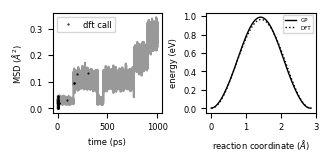

In [27]:
# make figure
fsize = 6
f, (ax1, ax2) = plt.subplots(1, 2)

# plot vertical line for every dft call
ax1.plot(times, msds, 'k-', alpha=0.4)

ax1.plot(dft_times_plot, dft_msds_plot, 'k.', label='dft call', markersize=1)

# liquid subplot
# ax3 = plt.axes([.25, .6, .35, .2])
# ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax3.plot(times[0 : 100], msds[0 : 100])
# ax3.plot(dft_times_plot[0 : 45], dft_msds_plot[0 : 45], 'k.', label='dft call')

ax1.legend(fontsize=fsize)
ax1.set_xlabel('time (ps)', fontsize=fsize)
ax1.set_ylabel('MSD ($\AA^2$)', fontsize=fsize)
ax1.tick_params(labelsize=fsize)

# ------------------------------
# part (b): activation profile
# ------------------------------
ax2.tick_params(labelsize=fsize)
ax2.set_xlabel('reaction coordinate ($\AA$)', fontsize=fsize)
ax2.set_ylabel('energy (eV)', fontsize=fsize)

ax2.plot(dists, test_en, 'k-', linewidth=1, label='GP')
ax2.plot(dists, dft_act, 'k:', linewidth=1, label='DFT')
ax2.legend(fontsize=4)

f.set_size_inches(3.4, 1.3)
f.subplots_adjust(wspace = 0.4)
f.savefig('/Users/jonpvandermause/Research/GP/otf/paper/Main/vac.pdf', format='pdf',bbox_inches='tight')
plt.show()

# Get activation profile

In [3]:
gp_cell = np.eye(3) * 8.092
kernel = kernels.two_body
kernel_grad = kernels.two_body_grad
algo = 'BFGS'
call_no = len(otf_run.gp_position_list)
cutoffs = np.array([5.4])
start_list = [0]

gp_model = otf_run.make_gp(gp_cell, kernel, kernel_grad, algo, call_no,
                           start_list, cutoffs)

In [4]:
fcc_cell = fcc_cell = np.eye(3) * 8.092 / 2
species = ['Al']*31
nop = 100
cutoff = 5.4
xval = np.linspace(0, 1, nop)

store_res = analyze_gp.vac_diff_fcc(gp_model, gp_cell, fcc_cell, species, cutoff, nop)

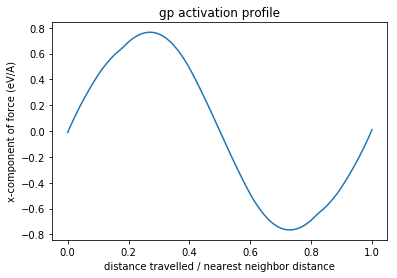

In [5]:
# plot x-component force predictions
plt.plot(xval, store_res[0, :])
plt.xlabel('distance travelled / nearest neighbor distance')
plt.ylabel('x-component of force (eV/A)')
plt.title('gp activation profile')
plt.show()

In [10]:
barrier_file = '/Users/jonpvandermause/Research/GP/data/Aluminum/Al_Barrier/barrier.txt'
energies, forces, positions = activation_parser.parse_barrier_file(barrier_file)
dft_act = (np.array(energies) - energies[0])*13.6056980659

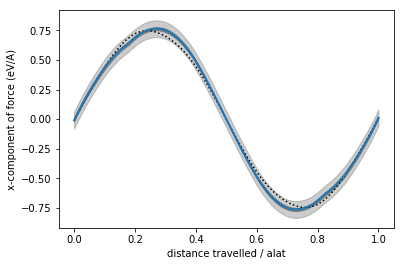

In [11]:
f = plt.figure()
dft_profile = []
for force in forces:
    dft_profile.append(force[0,0])

plt.plot(xval, dft_profile, 'k:')
plt.plot(xval, store_res[0, :], linewidth=2)
plt.fill_between(xval,
                 store_res[0, :] - np.sqrt(store_res[4, :] + 0.07016319**2),
                 store_res[0, :] + np.sqrt(store_res[4, :] + 0.07016319**2), color='k', alpha=0.2)
plt.fill_between(xval,
                 store_res[0, :] - np.sqrt(store_res[4, :]),
                 store_res[0, :] + np.sqrt(store_res[4, :]), color='k', alpha=0.3)

plt.xlabel('distance travelled / alat')
plt.ylabel('x-component of force (eV/A)')
plt.show()


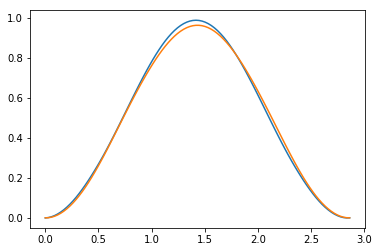

0.9882682833541945


In [13]:
# create 2x2x2 fcc supercell with atom 0 removed
nop = 100
alat = fcc_cell[0, 0]
fcc_unit = crystals.fcc_positions(alat)
fcc_super = crystals.get_supercell_positions(2, fcc_cell, fcc_unit)
vac_super = copy.deepcopy(fcc_super)
vac_super.pop(0)
vac_super = np.array(vac_super)

# create list of positions for the migrating atom
start_pos = vac_super[0]
end_pos = np.array([0, 0, 0])
diff_vec = end_pos - start_pos
test_list = []
step = diff_vec / (nop - 1)

step_mag = np.sqrt(step[0]**2 + step[1]**2)
fin_dist = np.sqrt(start_pos[0]**2 + start_pos[1]**2)
dists = np.linspace(0,fin_dist, nop)

fcc_cell = np.eye(3) * 8.092 / 2
alat = fcc_cell[0, 0]

test_fc = store_res[0,:]
test_en = []
en_curr = 0

for n in range(len(test_fc)):
    en_curr += np.sqrt(2) * test_fc[n] * step_mag
    test_en.append(en_curr)

test_en = np.array(test_en)

plt.plot(dists, test_en)
plt.plot(dists, dft_act)
plt.show()

print(max(test_en))